# Data Loading

This uses the labeled_data dataset

In [1]:
import pandas as pd
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import get_scheduler, AutoModelForSequenceClassification

In [2]:
# Load cvs file
data = pd.read_csv('../../data/HateSpeechDatasetBalanced.csv')
data.rename(columns={'Label': 'labels', 'Content': 'text'}, inplace=True)

# Equilibrate the dataset
data = data.groupby('labels').head(10000)

# Shuffle the dataset 
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print(data['labels'].value_counts())  
display(data)

labels
1    10000
0    10000
Name: count, dtype: int64


,text,labels
0,something must be done to halt this terrible w...,1
1,hey everyone i do not know really where to pos...,0
2,value your money value your dick don t buy tra...,0
3,is my awakening still in print,0
4,gay families are not ok whatever should stop a...,1
...,...,...
19995,and to all you hudeksem you know i am pulling ...,0
19996,oh fuck yeah,1
19997,if somebody commits a crime in the name of the...,0
19998,i base this post on the fact that i live a few...,0


In [3]:
# Split the dataset into training, validation and test sets
df_train = data[:int(len(data)*0.8)]
df_val = data[int(len(data)*0.8):int(len(data)*0.9)]
df_test = data[int(len(data)*0.9):]

# Create dataset from pandas dataframes
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train,
    'val': dataset_val,
    'test': dataset_test
})

# Tokenize the dataset

In [4]:
MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if MODEL_NAME == "gpt2":
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Training

In [5]:
# Create dataloaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=4)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=4)

In [6]:
# Download the model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
if MODEL_NAME == "gpt2":
    model.config.pad_token_id = model.config.eos_token_id

In [7]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Create a lr scheduler
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps
)

In [8]:
# Transfer model to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


  0%|          | 0/20000 [00:00<?, ?it/s]

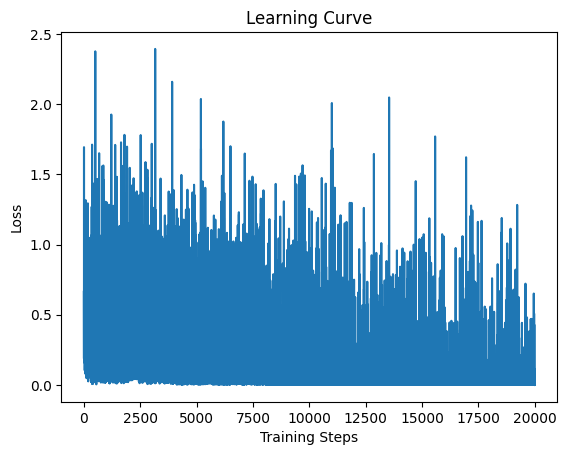

In [9]:
# Start the training loop
progress_bar = tqdm(range(num_training_steps))
loss_values = []

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch  = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loss_values.append(loss.item())
        progress_bar.update(1)

plt.plot(loss_values)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

# Model Evaluation

In [10]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

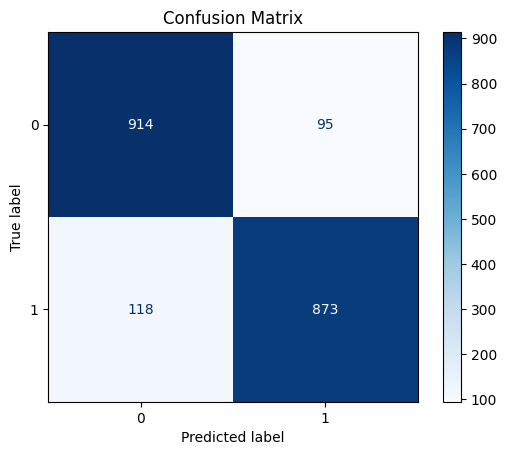

              precision    recall  f1-score   support

   Non-Toxic       0.89      0.91      0.90      1009
       Toxic       0.90      0.88      0.89       991

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [11]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
print(classification_report(all_labels, all_predictions, target_names=['Non-Toxic', 'Toxic']))

In [12]:
# Save the model
model.save_pretrained("gpt2")
tokenizer.save_pretrained("gpt2")

('gpt2/tokenizer_config.json',
 'gpt2/special_tokens_map.json',
 'gpt2/vocab.json',
 'gpt2/merges.txt',
 'gpt2/added_tokens.json',
 'gpt2/tokenizer.json')